<a href="https://colab.research.google.com/github/Balo0l/Balo0l.github.io/blob/main/RL_Maze_Q_Learning_Colab_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧭 Q-Learning a Robot Through a Maze — Student Edition (Colab)

In this notebook you'll **build a simple gridworld (maze)**, then implement **Q-learning** with an **epsilon-greedy** policy.
There are **fill-in-the-blank** cells (🧩 *Your turn*) to reinforce learning. A **reference solution** follows each task.

**Estimated time:** 45–60 minutes

### Learning outcomes
- Code up a digital environment (maze) with **obstacles**, **food**, and a **goal**  
- Implement the **Q-table**, **ε-greedy** action selection, and the **Q-learning update**  
- Visualize a learned path and **re-run** on any maze size / obstacle / food configuration  
- Transfer the same algorithm to any small discrete environment

## 0) Setup (NumPy + Matplotlib only)
Run this cell first.

In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

# For reproducibility (set to None for more randomness)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## 1) Q-Learning in one page

We learn a table of values **Q[state, action]**. We pick actions using **epsilon-greedy**:
- With probability **ε**: pick a **random** action (explore).
- With probability **1−ε**: pick the **best** action (exploit).

**Update rule** after taking action *a* in state *s*, landing in *s′* and getting reward *r*:

\begin{equation}
Q[s,a] \leftarrow Q[s,a] + \alpha \Big( r + \gamma \max_{a'} Q[s',a'] - Q[s,a] \Big)
\end{equation}

Where **α** is learning rate and **γ** is discount factor.

## 2A) 🧩 Your turn — Code a tiny Maze environment (skeleton)

We’ll represent states as **(row, col)** in a `rows × cols` grid.  
Symbols:
- **S** (start), **G** (goal), **X** (obstacle), **F** (food/bonus)

Actions: `0=Up, 1=Right, 2=Down, 3=Left`

**Rewards (suggested):**
- Step: `-0.1`
- Bump into wall/obstacle (no move): `-0.5`
- On food cell: `+1.0` (every entry)
- On goal cell: `+10.0` and episode ends

> Fill the TODOs below. Don’t worry — a complete reference version is in **2B**.

In [ ]:

class MazeEnvStudent:
    """
    Minimal gridworld skeleton for students.
    State index encoding: idx = row * cols + col
    """
    def __init__(self, rows, cols, obstacles=None, foods=None,
                 start=(0, 0), goal=None,
                 step_penalty=-0.1, bump_penalty=-0.5,
                 food_reward=1.0, goal_reward=10.0):
        # TODO: store rows, cols, start, goal (default goal: bottom-right)


        # TODO: convert obstacles/foods into sets; store reward parameters


        # Fixed action map
        self.actions = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1)   # Left
        }

        # Basic checks
        assert self.start[0] >= 0 and self.start[0] < rows
        assert self.start[1] >= 0 and self.start[1] < cols
        assert self.goal[0] >= 0 and self.goal[0] < rows
        assert self.goal[1] >= 0 and self.goal[1] < cols
        assert self.start not in self.obstacles
        assert self.goal not in self.obstacles

        self.reset()

    # --- Helpers ---
    def to_index(self, pos):
        r, c = pos
        return r * self.cols + c

    def to_pos(self, idx):
        return divmod(idx, self.cols)

    @property
    def n_states(self):
        return self.rows * self.cols

    @property
    def n_actions(self):
        return 4

    def in_bounds(self, pos):
        r, c = pos
        return (0 <= r < self.rows) and (0 <= c < self.cols)

    # --- Core API ---
    def reset(self):
        self.agent = tuple(self.start)
        return self.to_index(self.agent)

    def step(self, action):
        """
        Return: (next_state_index, reward, done)
        Moves blocked by obstacles/walls apply bump penalty and stay in place.
        """
        dr, dc = self.actions[action]
        nr, nc = self.agent[0] + dr, self.agent[1] + dc

        # TODO: start with step_penalty; set done=False


        # TODO: if next is out-of-bounds or obstacle -> add bump_penalty and stay


        # TODO: if next_pos is food -> add food_reward


        # TODO: if next_pos is goal -> add goal_reward and set done=True


        self.agent = next_pos
        return self.to_index(self.agent), reward, done


## 2B) ✅ Reference: Maze environment (used for the rest of the notebook)

You can compare to your version above. We’ll use this class for training & visualization.

In [2]:

class MazeEnv:
    def __init__(self, rows, cols, obstacles=None, foods=None,
                 start=(0, 0), goal=None,
                 step_penalty=-0.1, bump_penalty=-0.5,
                 food_reward=1.0, goal_reward=10.0):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = (rows - 1, cols - 1) if goal is None else goal

        self.obstacles = set(obstacles or [])
        self.foods = set(foods or [])
        self.step_penalty = step_penalty
        self.bump_penalty = bump_penalty
        self.food_reward = food_reward
        self.goal_reward = goal_reward

        self.actions = {0: (-1,0), 1: (0,1), 2: (1,0), 3: (0,-1)}

        assert self.in_bounds(self.start)
        assert self.in_bounds(self.goal)
        assert self.start not in self.obstacles
        assert self.goal not in self.obstacles

        self.reset()

    def in_bounds(self, pos):
        r, c = pos
        return 0 <= r < self.rows and 0 <= c < self.cols

    def to_index(self, pos):
        r, c = pos
        return r * self.cols + c

    def to_pos(self, idx):
        return divmod(idx, self.cols)

    @property
    def n_states(self):
        return self.rows * self.cols

    @property
    def n_actions(self):
        return 4

    def reset(self):
        self.agent = tuple(self.start)
        return self.to_index(self.agent)

    def step(self, action):
        dr, dc = self.actions[action]
        nr, nc = self.agent[0] + dr, self.agent[1] + dc

        reward = self.step_penalty
        done = False

        if not self.in_bounds((nr, nc)) or (nr, nc) in self.obstacles:
            reward += self.bump_penalty
            next_pos = self.agent
        else:
            next_pos = (nr, nc)

        if next_pos in self.foods:
            reward += self.food_reward

        if next_pos == self.goal:
            reward += self.goal_reward
            done = True

        self.agent = next_pos
        return self.to_index(self.agent), reward, done


## 2C) Grid visualization helper

This function draws the maze and (optionally) a path and max-Q labels.

In [3]:

def render_env(env, path=None, show_q=False, q_values=None):
    grid = np.zeros((env.rows, env.cols))

    for r, c in env.obstacles:
        grid[r, c] = -1
    for r, c in env.foods:
        grid[r, c] = 0.5

    sr, sc = env.start
    gr, gc = env.goal
    grid[sr, sc] = 0.75
    grid[gr, gc] = 1.0

    plt.figure(figsize=(min(10, 0.8*env.cols + 1), min(10, 0.8*env.rows + 1)))
    plt.imshow(grid, interpolation='nearest')
    plt.xticks(range(env.cols))
    plt.yticks(range(env.rows))
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.title("Maze: X=obstacle, F=food, S=start, G=goal")

    for r in range(env.rows):
        for c in range(env.cols):
            label = ""
            if (r, c) in env.obstacles:
                label = "X"
            elif (r, c) == env.start:
                label = "S"
            elif (r, c) == env.goal:
                label = "G"
            elif (r, c) in env.foods:
                label = "F"
            if label:
                plt.text(c, r, label, ha='center', va='center', fontsize=12, fontweight='bold')

    if path:
        xs = [c for r, c in path]
        ys = [r for r, c in path]
        plt.plot(xs, ys, linewidth=3, alpha=0.9)

    if show_q and (q_values is not None):
        for r in range(env.rows):
            for c in range(env.cols):
                idx = env.to_index((r, c))
                if (r, c) not in env.obstacles:
                    maxq = np.max(q_values[idx])
                    plt.text(c, r, f"{maxq:.1f}", ha='center', va='bottom', fontsize=9)

    plt.show()


### Try a demo maze

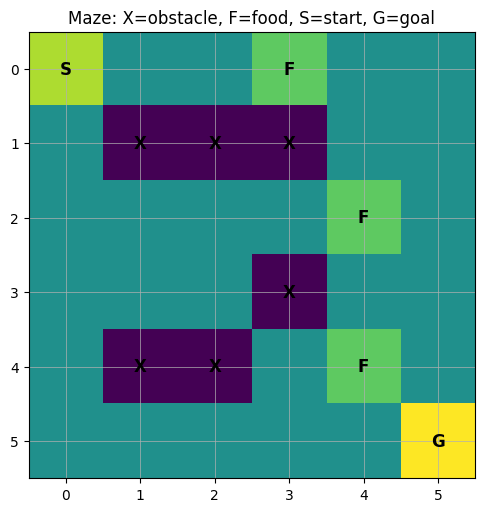

In [4]:

rows, cols = 6, 6
obstacles = {(1,1), (1,2), (1,3), (3,3), (4,1), (4,2)}
foods = {(0,3), (2,4), (4,4)}
env = MazeEnv(rows, cols, obstacles=obstacles, foods=foods)
render_env(env)


## 3A) 🧩 Your turn — Epsilon-greedy action

Write a function `epsilon_greedy_action(q_row, epsilon)` that:
- With probability ε returns a **random** action index
- Otherwise returns the index of the **max-Q** action (break ties randomly)

In [ ]:

def epsilon_greedy_action(q_row, epsilon):
    # TODO: with probability epsilon, pick a random action index
    # hint: np.random.rand() < epsilon


    # TODO: compute max Q, collect all indices that match it, and tiebreak randomly



## 3B) ✅ Reference: Epsilon-greedy

In [5]:

def epsilon_greedy_action_ref(q_row, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_row))
    max_q = np.max(q_row)
    candidates = np.flatnonzero(q_row == max_q)
    return np.random.choice(candidates)


## 4A) 🧩 Your turn — Q-learning training loop

Fill in the **update** using the formula above. Return the learned Q-table and a simple training history.

In [ ]:

def q_learning(env, episodes=600, max_steps=300, alpha=0.2, gamma=0.95,
               epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995,
               verbose_every=100):
    Q = np.zeros((env.n_states, env.n_actions), dtype=np.float32)
    rewards = []

    for ep in range(1, episodes + 1):
        s = env.reset()
        total_r = 0.0
        done = False

        for t in range(max_steps):
            a = epsilon_greedy_action(Q[s], epsilon)
            s_next, r, done = env.step(a)

            # TODO: compute td_target = r + gamma * max_a' Q[s_next, a'] * (0 if done else 1)

            # TODO: compute td_error = td_target - Q[s, a]

            # TODO: apply update: Q[s, a] += alpha * td_error

            s = s_next
            total_r += r
            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_r)

        if verbose_every and ep % verbose_every == 0:
            print(f"Episode {ep:4d} | avg reward(last {verbose_every}) = {np.mean(rewards[-verbose_every:]):.2f} | epsilon={epsilon:.3f}")

    history = {"episode_rewards": np.array(rewards, dtype=np.float32)}
    return Q, history


## 4B) ✅ Reference: Q-learning (used for the rest)

In [6]:

def q_learning_ref(env, episodes=800, max_steps=300, alpha=0.2, gamma=0.95,
                   epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995,
                   verbose_every=100):
    Q = np.zeros((env.n_states, env.n_actions), dtype=np.float32)
    rewards = []

    for ep in range(1, episodes + 1):
        s = env.reset()
        total_r = 0.0
        done = False

        for _ in range(max_steps):
            a = epsilon_greedy_action_ref(Q[s], epsilon)
            s_next, r, done = env.step(a)

            td_target = r + gamma * np.max(Q[s_next]) * (0.0 if done else 1.0)
            td_error = td_target - Q[s, a]
            Q[s, a] += alpha * td_error

            s = s_next
            total_r += r
            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_r)

        if verbose_every and ep % verbose_every == 0:
            print(f"Episode {ep:4d} | avg reward(last {verbose_every}) = {np.mean(rewards[-verbose_every:]):.2f} | epsilon={epsilon:.3f}")

    history = {"episode_rewards": np.array(rewards, dtype=np.float32)}
    return Q, history


## 5) Train on the demo maze

If you completed your own functions, try `q_learning`. Otherwise, run the reference `q_learning_ref`.

Episode  100 | avg reward(last 100) = 2.96 | epsilon=0.606
Episode  200 | avg reward(last 100) = 11.51 | epsilon=0.367
Episode  300 | avg reward(last 100) = 12.00 | epsilon=0.222
Episode  400 | avg reward(last 100) = 11.94 | epsilon=0.135
Episode  500 | avg reward(last 100) = 12.09 | epsilon=0.082
Episode  600 | avg reward(last 100) = 11.92 | epsilon=0.050
Episode  700 | avg reward(last 100) = 12.02 | epsilon=0.050
Episode  800 | avg reward(last 100) = 12.04 | epsilon=0.050


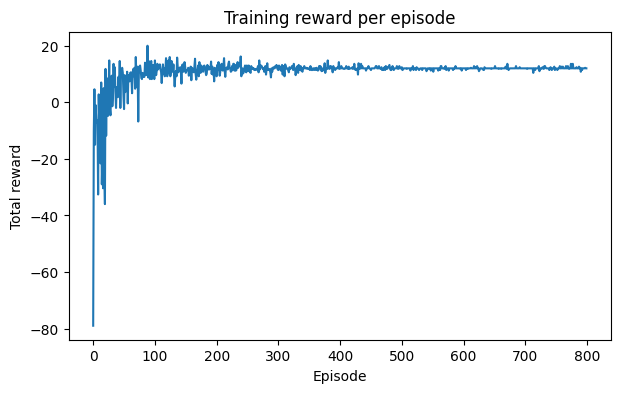

Max Q of first 10 states:
 [7.875 8.394 8.941 8.465 9.015 8.465 7.381 0.    0.    0.   ]


In [7]:

# Choose one:
# Q, hist = q_learning(env, episodes=800)        # <-- use if you completed your version
Q, hist = q_learning_ref(env, episodes=800)       # <-- reference

# Plot rewards
plt.figure(figsize=(7,4))
plt.plot(hist["episode_rewards"])
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Training reward per episode")
plt.show()

print("Max Q of first 10 states:\n", np.max(Q, axis=1)[:10])


## 6) Visualize the learned behavior (greedy)

We’ll run a **greedy** episode (ε=0) and draw the path.

Greedy episode: total reward = 12.00, success = True


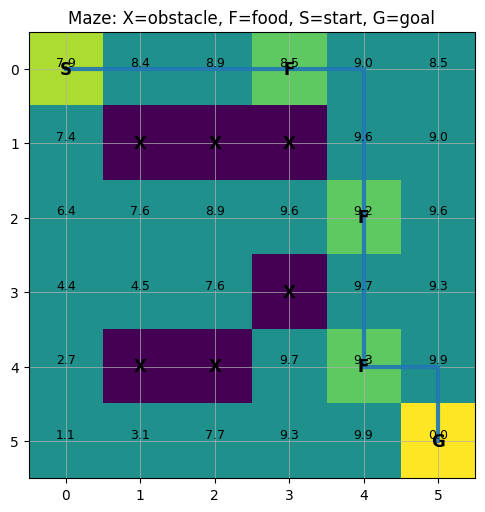

In [8]:

def rollout_greedy(env, Q, max_steps=300):
    s = env.reset()
    path = [env.to_pos(s)]
    total_r = 0.0
    done = False

    for _ in range(max_steps):
        a = np.argmax(Q[s])
        s, r, done = env.step(a)
        path.append(env.to_pos(s))
        total_r += r
        if done:
            break

    return path, total_r, done

path, total_r, done = rollout_greedy(env, Q)
print(f"Greedy episode: total reward = {total_r:.2f}, success = {done}")
render_env(env, path=path, show_q=True, q_values=Q)


## 7) Generate **any** maze and re-train

This helper keeps a path from **S** to **G** by resampling obstacles until connected.

In [9]:

from collections import deque

def neighbors(pos, rows, cols):
    r, c = pos
    for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
        nr, nc = r+dr, c+dc
        if 0 <= nr < rows and 0 <= nc < cols:
            yield (nr, nc)

def has_path(rows, cols, obstacles, start, goal):
    blocked = set(obstacles)
    if start in blocked or goal in blocked:
        return False
    q = deque([start])
    seen = {start}
    while q:
        cur = q.popleft()
        if cur == goal:
            return True
        for nxt in neighbors(cur, rows, cols):
            if nxt not in seen and nxt not in blocked:
                seen.add(nxt)
                q.append(nxt)
    return False

def random_maze(rows=10, cols=12, n_obstacles=20, n_food=8, start=(0,0), goal=None, attempts=2000, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    goal = (rows-1, cols-1) if goal is None else goal

    all_cells = [(r,c) for r in range(rows) for c in range(cols) if (r,c) not in (start, goal)]
    for _ in range(attempts):
        obs_k = min(n_obstacles, len(all_cells))
        obstacles = set(random.sample(all_cells, k=obs_k))
        obstacles.discard(start)
        obstacles.discard(goal)

        if not has_path(rows, cols, obstacles, start, goal):
            continue

        free_cells = [c for c in all_cells if c not in obstacles]
        foods = set(random.sample(free_cells, k=min(n_food, len(free_cells))))
        foods.discard(start); foods.discard(goal)

        return MazeEnv(rows, cols, obstacles=obstacles, foods=foods, start=start, goal=goal)

    raise RuntimeError("Failed to generate a connected maze. Try fewer obstacles or more attempts.")


### Example: New maze → train → visualize

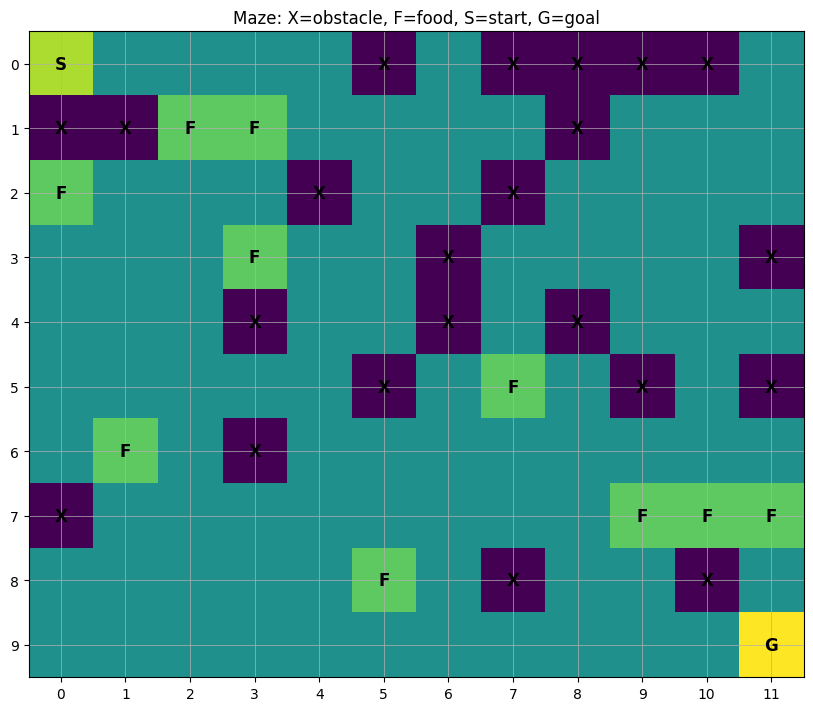

Episode  200 | avg reward(last 200) = 49.61 | epsilon=0.548
Episode  400 | avg reward(last 200) = 165.10 | epsilon=0.301
Episode  600 | avg reward(last 200) = 216.93 | epsilon=0.165
Episode  800 | avg reward(last 200) = 240.30 | epsilon=0.090
Episode 1000 | avg reward(last 200) = 253.73 | epsilon=0.050
Episode 1200 | avg reward(last 200) = 257.49 | epsilon=0.050
Episode 1400 | avg reward(last 200) = 257.34 | epsilon=0.050
Episode 1600 | avg reward(last 200) = 257.16 | epsilon=0.050
Episode 1800 | avg reward(last 200) = 257.94 | epsilon=0.050
Episode 2000 | avg reward(last 200) = 257.29 | epsilon=0.050
Episode 2200 | avg reward(last 200) = 257.27 | epsilon=0.050
Episode 2400 | avg reward(last 200) = 257.16 | epsilon=0.050
Episode 2600 | avg reward(last 200) = 257.05 | epsilon=0.050
Episode 2800 | avg reward(last 200) = 257.52 | epsilon=0.050
Episode 3000 | avg reward(last 200) = 257.25 | epsilon=0.050


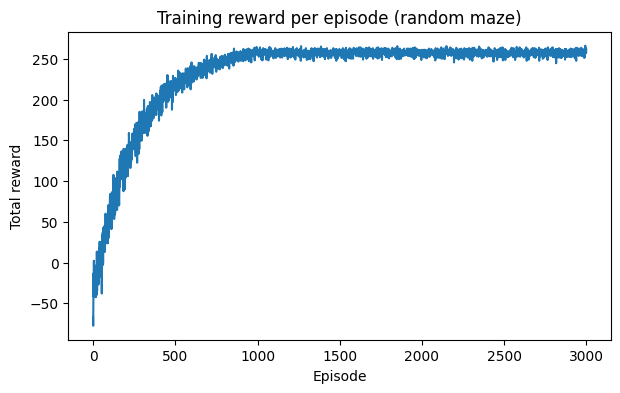

Greedy on random maze: total reward = 268.00, success = False


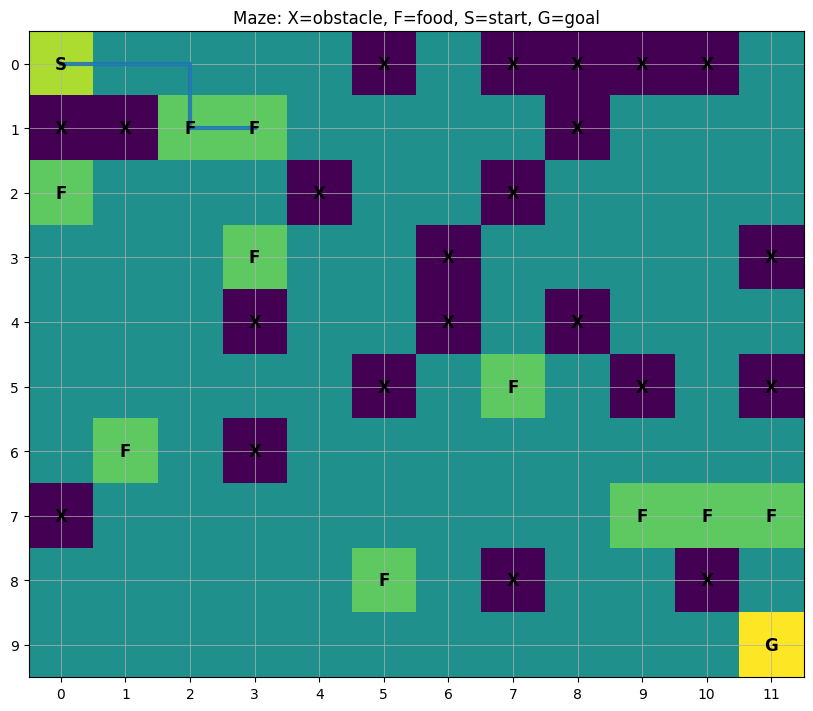

In [12]:

env2 = random_maze(rows=10, cols=12, n_obstacles=22, n_food=10, seed=7)
render_env(env2)

Q2, hist2 = q_learning_ref(env2, episodes=3000, epsilon_decay=0.997, verbose_every=200)

plt.figure(figsize=(7,4))
plt.plot(hist2["episode_rewards"])
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Training reward per episode (random maze)")
plt.show()

path2, total_r2, done2 = rollout_greedy(env2, Q2)
print(f"Greedy on random maze: total reward = {total_r2:.2f}, success = {done2}")
render_env(env2, path=path2, show_q=False)


## 8) Transfer these skills (beyond mazes)
- States can be anything you can **index** (game positions, discrete robot poses, inventory levels, ...)
- Keep the same **`q_learning`**; just swap in a new environment with `reset()`, `step(a)`, `n_states`, `n_actions`.

## 9) Quick mini-exercises (optional)
1. Make food +0.5 or +2.0 and observe changes.
2. Make food consumable once per episode (hint: track a set of remaining foods in the env; for perfect Markov state you’d include it in state).
3. Try bigger mazes and compare episode counts to succeed.
4. Try a constant ε = 0.1 vs. decay.
5. Add a time penalty for long episodes (cap steps and subtract a final penalty if not at goal).